# Imports

In [ ]:
import torch
torch.cuda.is_available()

False

In [1]:
fig_num = 0

In [2]:
import pandas as pd
pd.set_option("max_colwidth", 160)
pd.set_option("display.max_columns", None)

import numpy as np

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.style.use("seaborn-talk")



def load_data(file_path, indx = True, indx_col = 0):
  '''Parameters:
  file_path: path to your excel or csv file with data,

  indx: boolean - whether there is index column in your file (usually it is the first column) --> *by default it is set to True
  
  indx_col: int - if your file has an index column, specify column number here --> *by default it is equal to 0 (first column)
  '''
  if indx == True and file_path.endswith(".xlsx"):
    data = pd.read_excel(file_path, index_col = indx_col)
  elif indx == False and file_path.endswith(".xlsx"):
    data = pd.read_excel(file_path)

  elif indx == True and file_path.endswith(".csv"):
    data = pd.read_csv(file_path, index_col = indx_col)
  elif indx == False and file_path.endswith(".csv"):
    data = pd.read_csv(file_path)
  return data


In [ ]:
def lemmatization(dataframe, text_column):
  '''Parameters:
  dataframe: dataframe with your data,
  
  text_column: column of a dataframe where text is located
  '''
  df = dataframe.copy()
  lemmas = []
  for doc in nlp.pipe(df[text_column].apply(str)):
    lemmas.append(" ".join([token.lemma_ for token in doc if (not token.is_punct and not token.is_stop and not token.like_num and len(token) > 1) ]))
  df[text_column+"_lemmatized"] = lemmas
  return df



# this function by analogy to ENG debates for polarity / valence measures
def get_valence_scores(data, content_lemmatized_column, affective_database, db_words = "Word"):
  '''Parameters: 
  dataframe: dataframe with your data,

  content_lemmatized_column: str - name of a column in dataframe where word-lemmas are listed, 
  
  affective_database_path: str - path to a file with affective database, 
  
  db_words: str - name of a column in affective database where words are listed, 
  '''  
  dataframe = data.copy()
  #affective_database = load_data(affective_database_path)

  emotion_values = ["Valence_standardized"]
  used_cols = [db_words] + emotion_values

  affective_database_valence = affective_database[used_cols]
  affective_database_valence.set_index(db_words, inplace=True)
  affective_database_valence_words = affective_database[db_words].tolist()

  neg_valence_scores = []
  pos_valence_scores = []

  overall_scores_pos = []
  overall_scores_neg = []
  overall_scores = []

  for row in dataframe[content_lemmatized_column]:
    words_emo = row.split()
    if len(row) > 0:
      scores = affective_database_valence.loc[words_emo]

      neg_score = scores.where(scores["Valence_standardized"].round(1) < -0.5).count()[0]
      neg_valence_scores.append(neg_score)

      pos_score = scores.where(scores["Valence_standardized"].round(1) > 1).count()[0]
      pos_valence_scores.append(pos_score)

      neg_score2 = abs(scores.where(scores["Valence_standardized"] < -0.5).mean()[0])
      if not (neg_score2 >= 0 and neg_score2 <= 4):
        neg_score2 = 0

      pos_score2 = scores.where(scores["Valence_standardized"] > 1).mean()[0]
      if not (pos_score2 >= 0 and pos_score2 <= 4):
        pos_score2 = 0

      overall_scores_pos.append(pos_score2)
      overall_scores_neg.append(neg_score2)
      if pos_score2 > neg_score2:
        overall_scores.append(pos_score2)
      elif pos_score2 < neg_score2:
        overall_scores.append(neg_score2 * -1)
      elif pos_score2 == neg_score2:
        overall_scores.append(0)

    else:
      neg_score=pos_score=polarity_score=score_overall = np.NaN
      overall_scores.append(score_overall)
      overall_scores_pos.append(score_overall)
      overall_scores_neg.append(score_overall)
      neg_valence_scores.append(neg_score)
      pos_valence_scores.append(pos_score)

  dataframe["content_valence_score"] = overall_scores
  dataframe["content_valence_score_pos"] = overall_scores_pos
  dataframe["content_valence_score_neg"] = overall_scores_neg
  dataframe["content_valence_negative"] = neg_valence_scores
  dataframe["content_valence_positive"] = pos_valence_scores
  return dataframe  


In [ ]:
!python -m spacy download pl_core_news_md --quiet


[+] Download and installation successful
You can now load the package via spacy.load('pl_core_news_md')



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:

import spacy

# load SPACY model
nlp = spacy.load('pl_core_news_md')

In [ ]:
def clean_text(df, text_column):
  import re
  new_texts = []
  for text in df[text_column]:
    text_list = str(text).lower().split(" ")
    new_string_list = []
    for word in text_list:
      if 'http' in word:
        word = "url"
      elif ('@' in word) and (len(word) > 1):
        word = "user"
      if (len(word) > 1) and not (word.isnumeric()):
        new_string_list.append(word)
    new_string = " ".join(new_string_list)
    new_string = re.sub("\d+", " ", new_string)
    new_string = new_string.replace('\n', ' ')
    new_string = new_string.replace('\r', ' ')
    new_string = new_string.strip()
    new_texts.append(new_string)
  df[text_column] = new_texts
  return df

# Merge single datasets

In [88]:
df1 = pd.read_csv(r"C:\Users\user1\Downloads\gazeta2_cln.csv", index_col=0)
df1.shape

(205701, 21)

In [89]:
sent1 = pd.read_csv(r"C:\Users\user1\Downloads\gazeta2_cln_sentimentBERT.csv")

df1 = pd.concat( [df1, sent1], axis=1 )
df1.shape

(205701, 22)

In [100]:
df2 = pd.read_csv(r"C:\Users\user1\Downloads\interia2_cln.csv", index_col=0)
df2.shape

(647289, 22)

In [101]:
sent2 = pd.read_csv(r"C:\Users\user1\Downloads\interia2_cln_sentimentBERT.csv")
sent2.shape

(647289, 1)

In [102]:
df2 = pd.concat( [df2, sent2], axis=1 )
df2.shape

(647289, 23)

In [90]:
df3 = pd.read_csv(r"C:\Users\user1\Downloads\interia1_cln.csv", index_col=0)
df3.shape

(1599878, 22)

In [93]:
205701+647289+1599878

2452868

In [121]:
sent1 = pd.read_csv(r"C:\Users\user1\Downloads\interia1_cln_sentimentBERT_750k.csv")
sent2 = pd.read_csv(r"C:\Users\user1\Downloads\interia1_cln_sentimentBERT_750k-1mln.csv", header=  None)
sent3 = pd.read_csv(r"C:\Users\user1\Downloads\interia1_cln_sentimentBERT_1mln.csv", header=  None)

sent1.shape[0] + sent2.shape[0] + sent3.shape[0]

1599878

In [ ]:
sent2.columns = sent1.columns
sent3.columns = sent1.columns
sent = pd.concat( [sent1, sent2, sent3], axis=0, ignore_index=True )

sent.to_csv(r"C:\Users\user1\Downloads\interia1_cln_sentimentBERT.csv", index=False)

In [91]:
df3 = pd.concat( [df3, sent], axis=1 )
df3.head(1) # 1599878

,id,voteup,content,month,content_lemmatized,valence_words,neg_valence_words,pos_valence_words,content_valence_negative,content_valence_positive,content_valence_score_neg,content_valence_score_pos,content_valence_score,neg_percent,pos_percent,month_resp_dob,month_resp_zla,month_resp,valence_pos,valence_neg,prop_neg,prop_pos,sentimentBERT
0,213257700,440,"polska pod rządami pisu kojarzy mi się filmem ""miś"" oraz anegdotami wąchocku",5,Polska rząd pis kojarzyć film miś anegdota wąchock,rząd film miś,rząd,miś film,1.0,2.0,7.415875,12.519472,12.519472,12.5,25.0,22,42.0,-20.0,1,0,NaN,30.309931,Negative


In [95]:
df3.shape

(1599878, 23)

In [104]:
df_all = pd.concat( [df1, df2, df3], axis=0, ignore_index=True )
df_all.head(2)

,id,parentId,content,timestamp,month,content_lemmatized,valence_words,content_valence_score,content_valence_score_pos,content_valence_score_neg,content_valence_negative,content_valence_positive,neg_percent,pos_percent,month_resp_dob,month_resp_zla,month_resp,valence_pos,valence_neg,prop_neg,prop_pos,sentimentBERT,voteup,content_valence_score_norm,month_resp_norm,neg_valence_words,pos_valence_words
0,59304307,59304103.0,"user ze względu na pandemię strach było jechać do włoch lub grecji gdyby był wybór, to na pewno nie byłby bałtyk. lipcu było zimno.",2020-11-17 18:27:57,11,user wzgląd pandemia strach jechać włochy grecja wybór pewno być by Bałtyk lipiec zimno,strach włochy zimno,-12.566158,11.211297,12.566158,2.0,1.0,14.285714,7.142857,14,45.0,-31.0,0,1,33.517117,NaN,Negative,NaN,NaN,NaN,NaN,NaN
1,59304524,59304103.0,"user samo mówią, że nie jadają maku, między gorzowem, szczecinem latem nie ma jak zatankować.",2020-11-17 18:42:55,11,user samo mówić jadać mak gorzowo szczecinem lato zatankować,lato,19.440892,19.440892,0.000000,0.0,1.0,0.000000,11.111111,14,45.0,-31.0,1,0,NaN,29.715291,Negative,NaN,NaN,NaN,NaN,NaN


In [105]:
df_all.info(True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452868 entries, 0 to 2452867
Data columns (total 27 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   id                          2452868 non-null  int64  
 1   parentId                    205701 non-null   float64
 2   content                     2452868 non-null  object 
 3   timestamp                   205701 non-null   object 
 4   month                       2452868 non-null  int64  
 5   content_lemmatized          2452868 non-null  object 
 6   valence_words               1835419 non-null  object 
 7   content_valence_score       1835419 non-null  float64
 8   content_valence_score_pos   1835419 non-null  float64
 9   content_valence_score_neg   1835419 non-null  float64
 10  content_valence_negative    1835419 non-null  float64
 11  content_valence_positive    1835419 non-null  float64
 12  neg_percent                 1835419 non-null  float64
 1

In [107]:
df_all.to_csv(r"C:\Users\user1\Downloads\wnpid_all_sentiBERT.csv")
df_all.shape # 2452868

(2452868, 27)

In [108]:
df_all['month'].value_counts()

3     628300
6     396646
7     386781
5     319533
10    223087
8     218733
9     209304
11     67698
1       1500
2       1286
Name: month, dtype: int64

# Data single processing

In [ ]:
df = pd.read_csv(r"C:\Users\user1\Downloads\interia1.csv", index_col=0)
df.shape

(3041841, 8)

In [ ]:
df.head(3)

,datetime,replyCount,votedown,author,parentCommentId,id,voteup,content
0,2020-05-14 16:06:09,14,113,18latek,NaN,213257700,440,"Polska pod rządami pisu kojarzy mi się z filmem ""Miś"" oraz z anegdotami o Wąchocku"
1,2020-05-14 15:50:58,3,47,ityle,NaN,213256643,332,........o kaczor mu nie dał wytycznych i bidaczysko nie wie co ma podpisać.
2,2020-05-14 15:49:54,0,17,Ckd,NaN,213256576,267,Jak zwykle tytułZdupy.


In [ ]:
df = df.drop_duplicates(['content'])
df.shape

(2452007, 8)

In [ ]:
df['month'] = pd.to_datetime(df.datetime).dt.month
df = df[df.month.isin([1, 2, 3, 5, 6, 7, 8, 9, 10, 11])]
#df['month'] = np.where(df['month'].isin([5, 6]), 6, df['month'])
df['month'].value_counts()

3     733426
6     455743
5     364219
7     286624
8       6210
9       4854
10      1601
Name: month, dtype: int64

In [ ]:
df.shape

(1852677, 9)

In [ ]:
df['content'] = df['content'].apply(str)
df = df[df.content.str.split().map(len) > 2]
df.shape

(1769872, 9)

In [ ]:
df = clean_text(df, 'content')
df = df[df.content.str.split().map(len) > 2]
df.shape

(1752708, 9)

In [ ]:
df = df.drop_duplicates(['content'])
df.shape

(1733609, 9)

In [ ]:
df.iloc[765:768]

,datetime,replyCount,votedown,author,parentCommentId,id,voteup,content,month
802,2020-05-15 10:54:22,0,2,Chroń/Polskę,NaN,213310845,28,"matko córko. jeden uważa, że niepotrzebna nam stolica skoro jest berlin, drugi chce ""dożynać"" ludzi. czy peło nie ma już normalnych ludzi ????. to może jach...",5
803,2020-05-15 10:31:42,0,1,Leron,NaN,213308947,27,"wyborów nie można przeprowadzić trosce zdrowie polaków, ale spacer opuszczoną maseczką to już nie problem, bo to inteligencja studiowała usa, wirusa nie roz...",5
804,2020-05-15 11:48:07,0,2,ola,NaN,213314968,28,co jeden to lepszy.,5


In [ ]:
##

df.iloc[:, 5:].to_csv(r"C:\Users\user1\Downloads\interia1_cln.csv")

In [ ]:
df = lemmatization(df, 'content')
df.iloc[65:70, 5:]

,id,voteup,content,month,content_lemmatized
66,213272819,30,"to koniec kasy .....albo demokratyczny albo krwawy ,,, suweren już nie odpuści !!!!!",5,koniec kasa demokratyczny krwawy suweren odpuścić
67,213277976,30,co ma władza wykonawcza ma do rządzenia władzy sądowniczej?,5,władza wykonawczy rządzić władza sądowniczy
68,213278052,30,"duduś naważył piwa duduś powinien je wypić, nie chować głowę piasek.",5,duduś naważyć piwo duduś wypić chować głowa piasek
69,213268429,28,"""prezydent andrzej duda nie ma zamiaru na nowo angażować się spór władzę sądzie najwyższym. zaangażowal się już , jak zawetował ustawę. niech się sami wybi...",5,prezydent Andrzej duda zamiar nowo angażować spór władza sąd najwyższy zaangażowal zawetować ustawa sam wybierać
70,213266418,35,kto wsadził do sn tego zagrzybionego piżamowca,5,wsadzić sn zagrzybionego piżamowca


In [ ]:
##

df.iloc[:, 5:].to_csv(r"C:\Users\user1\Downloads\interia1_cln.csv")

In [ ]:
affdb = load_data(r"C:\Users\user1\Downloads\valence_db.xlsx")
print(affdb.shape)
affdb.head(2)

(10806, 4)


,Word,Database,Valence,Valence_standardized
0,Maczkowy,Sentimenti,0.566481,0.419659
1,abderyta,Sentimenti,0.402546,-0.553951


In [ ]:
affdb2 = affdb[ (affdb.Valence_standardized < -0.5) | (affdb.Valence_standardized > 1) ]
affdb2.shape

(4960, 4)

In [ ]:
affdb2['Word'] = affdb2['Word'].str.lower()
aff_words = affdb2['Word'].values
aff_words[:5]

array(['abderyta', 'aberracyjny', 'absmak', 'absurd', 'absurdalny'],
      dtype=object)

In [ ]:
#emotive_words = [word for word in lemmas_list if word in affective_database_valence_words]

df['valence_words'] = df['content_lemmatized'].apply(lambda x: " ".join( [w for w in str(x).split() if w in aff_words] ))
df['valence_words'].iloc[500:503]

523    nieszczęśliwy miłość gej
524                         gej
525               pobić partner
Name: valence_words, dtype: object

In [ ]:
df = df[df.content_lemmatized.str.split().map(len) > 2]
df.shape

(1599878, 11)

In [ ]:
df.iloc[80:83, 5:]

,id,voteup,content,month,content_lemmatized,valence_words
86,213264848,27,"nie będzie się angażował, czy to kogokolwiek zadziwi panie pałacyk jeszcze tylko kilka miesięcy baj, baj nikt polaków nie będzie robił sobie jaj.",5,angażować ktokolwiek zadziwić pani pałacyk miesiąc baj baj nikt polak robić jajo,nikt
87,213260340,38,prezesa sn powinien wybierać naród powszechnych wyborach.,5,prezes sn wybierać naród powszechny wybory,NaN
88,213262471,23,"jednym zdaniem, pan prezydent zrobi wszystko, by nie zrobić niczego.",5,zdanie prezydent zrobić zrobić nic,NaN


In [ ]:
##

df.iloc[:, 5:].to_csv(r"C:\Users\user1\Downloads\interia1_cln.csv")

In [ ]:
neg_words = set(affdb[ (affdb.Valence_standardized < -0.5) ]['Word'].values)
pos_words = set(affdb[ (affdb.Valence_standardized > 1) ]['Word'].values)

neg_affdb = affdb[ (affdb.Valence_standardized < -0.5)].set_index('Word')
pos_affdb = affdb[ (affdb.Valence_standardized > 1) ].set_index('Word')
pos_affdb.head(2)

,Database,Valence,Valence_standardized
Word,,,
adopcja,Sentimenti,0.829397,1.98111
akademicki,Sentimenti,0.666014,1.01078


In [ ]:
#df_null_val = df[df['valence_words'].isna()]
#df_full_val = df[ ~(df['valence_words'].isna())]

df_null_val = df_all[df_all['valence_words'] == 'nan']
df_full_val = df_all[df_all['valence_words'] != 'nan']

df_null_val.shape, df_full_val.shape

((196854, 24), (2256014, 24))

In [ ]:
df_all.shape

(2452868, 24)

In [ ]:
# 1st method --  faster to compute


df_full_val['valence_words'] = df_full_val['valence_words'].apply(str)
df_null_val['valence_words'] = df_null_val['valence_words'].apply(str)

#df_full_val['neg_valence_words'] = df_full_val['valence_words'].apply(lambda x: " ".join( set(str(x).split()).intersection(neg_words) ))
#df_full_val['pos_valence_words'] = df_full_val['valence_words'].apply(lambda x: " ".join( set(str(x).split()).intersection(pos_words) ))
df_full_val['neg_valence_words'] = df_full_val['valence_words'].apply(lambda x: " ".join( [w for w in str(x).split() if w in neg_words]) )
df_full_val['pos_valence_words'] = df_full_val['valence_words'].apply(lambda x: " ".join( [w for w in str(x).split() if w in pos_words]) )


df_full_val['content_valence_negative'] = df_full_val['neg_valence_words'].str.split().map(len)
df_full_val['content_valence_positive'] = df_full_val['pos_valence_words'].str.split().map(len)
df_full_val['content_valence_negative'] = np.where(df_full_val.valence_words.str.split().map(len) > 0, df_full_val['content_valence_negative'], np.nan)
df_full_val['content_valence_positive'] = np.where(df_full_val.valence_words.str.split().map(len) > 0, df_full_val['content_valence_positive'], np.nan)


df_full_val['content_valence_score_neg'] = df_full_val.neg_valence_words.apply(lambda x: np.abs(neg_affdb.loc[ str(x).split() ]['Valence_standardized'].mean()))
df_full_val['content_valence_score_pos'] = df_full_val.pos_valence_words.apply(lambda x: np.abs(pos_affdb.loc[ str(x).split() ]['Valence_standardized'].mean()))
df_full_val['content_valence_score_neg'] = df_full_val['content_valence_score_neg'].fillna(0)
df_full_val['content_valence_score_pos'] = df_full_val['content_valence_score_pos'].fillna(0)

df_full_val['content_valence_score'] = np.where(df_full_val['content_valence_score_neg'] > df_full_val['content_valence_score_pos'], df_full_val['content_valence_score_neg']*-1, 0)
df_full_val['content_valence_score'] = np.where(df_full_val['content_valence_score_neg'] < df_full_val['content_valence_score_pos'], df_full_val['content_valence_score_pos'], df_full_val['content_valence_score'])


In [ ]:
# 2nd method: with a dedicated function -- slower bc of the "for loop"


df_null_val = df[df.valence_words.str.split().map(len) < 1]
df_full_val = df[df.valence_words.str.split().map(len) > 0]

cols_literal2 = {'valence_words'} 

for col in cols_literal2:
  print(col)
  df_full_val = get_valence_scores(df_full_val, content_lemmatized_column = col, 
                        affective_database = affdb2)

df_full_val.head(3)

valence_words


,nestedReplies,votesRank,votesCount,replies,author,id,parentId,content,timestamp,month,content_lemmatized,valence_words,content_valence_score,content_valence_score_pos,content_valence_score_neg,content_valence_negative,content_valence_positive
1370,0,4,4,0,mawik_net,59304307,59304103,"user ze względu na pandemię strach było jechać do włoch lub grecji gdyby był wybór, to na pewno nie byłby bałtyk. lipcu było zimno.",2020-11-17 18:27:57,11,user wzgląd pandemia strach jechać włochy grecja wybór pewno być by Bałtyk lipiec zimno,strach włochy zimno,-1.256616,1.121130,1.256616,2,1
1371,0,3,3,0,eselk,59304524,59304103,"user samo mówią, że nie jadają maku, między gorzowem, szczecinem latem nie ma jak zatankować.",2020-11-17 18:42:55,11,user samo mówić jadać mak gorzowo szczecinem lato zatankować,lato,1.944089,1.944089,0.000000,0,1
1372,0,3,3,0,ladychapel,59304157,0,"jezeli baltyk to tylko neringa, gdzie kilometr na prawo kilometr na lewo nikogo innego",2020-11-17 18:13:22,11,baltyk neringa kilometr prawo kilometra lewo nikt inny,lewo nikt,-1.636472,0.000000,1.636472,2,0


In [ ]:
df = pd.concat( [df_full_val, df_null_val], axis=0 )
df.shape

(2452868, 24)

In [ ]:
df.head()

,id,parentId,content,timestamp,month,content_lemmatized,valence_words,content_valence_score,content_valence_score_pos,content_valence_score_neg,content_valence_negative,content_valence_positive,neg_percent,pos_percent,month_resp_dob,month_resp_zla,month_resp,valence_pos,valence_neg,prop_neg,prop_pos,voteup,neg_valence_words,pos_valence_words
0,59304307,59304103.0,"user ze względu na pandemię strach było jechać do włoch lub grecji gdyby był wybór, to na pewno nie byłby bałtyk. lipcu było zimno.",2020-11-17 18:27:57,11,user wzgląd pandemia strach jechać włochy grecja wybór pewno być by Bałtyk lipiec zimno,strach włochy zimno,-1.256616,0.000000,1.256616,2.0,0.0,14.285714,7.142857,14,45.0,-31.0,0,1,34.065999,NaN,NaN,strach zimno,
1,59304524,59304103.0,"user samo mówią, że nie jadają maku, między gorzowem, szczecinem latem nie ma jak zatankować.",2020-11-17 18:42:55,11,user samo mówić jadać mak gorzowo szczecinem lato zatankować,lato,1.944089,1.944089,0.000000,0.0,1.0,0.000000,11.111111,14,45.0,-31.0,1,0,NaN,29.497179,NaN,,lato
2,59304157,0.0,"jezeli baltyk to tylko neringa, gdzie kilometr na prawo kilometr na lewo nikogo innego",2020-11-17 18:13:22,11,baltyk neringa kilometr prawo kilometra lewo nikt inny,lewo nikt,-1.636472,0.000000,1.636472,2.0,0.0,25.000000,0.000000,14,45.0,-31.0,0,1,34.065999,NaN,NaN,lewo nikt,
3,59304655,59304214.0,"user jest uzasadnienie: ""kilometr na prawo kilometr na lewo nikogo innego"". umiesz czytać rozumieć?",2020-11-17 18:51:19,11,user uzasadnienie kilometr prawo kilometra lewo nikt inny umieć czytać rozumieć,lewo nikt czytać rozumieć,-1.636472,1.173201,1.636472,2.0,2.0,18.181818,18.181818,14,45.0,-31.0,0,0,NaN,NaN,NaN,lewo nikt,czytać rozumieć
4,59304304,0.0,"przypominając sobie początek tej pandemii, wszystko rozpoczęło się medialnie austrii. już wtedy chodziło tylko kontakty międzyludzkie. to że ludzie zjechali...",2020-11-17 18:27:38,11,przypominać początek pandemia rozpocząć medialnie austria chodzić kontakt międzyludzki człowiek zjechać miejsce spowodować przekazać wirus urlopowikać morze...,początek przekazać wirus morze góra przekazać wirus problem,-1.882922,1.255949,1.882922,3.0,5.0,9.375000,12.500000,14,45.0,-31.0,1,0,NaN,29.497179,NaN,wirus wirus problem,początek przekazać morze góra przekazać


In [ ]:
df.to_csv(r"C:\Users\user1\Downloads\wnpid_all2.csv") # valence words allow duplicates

In [ ]:
df = df.reset_index(drop=True)
df.shape

(2452868, 24)

In [ ]:
df.groupby('month', as_index=False).size()

,month,size
0,1,1500
1,2,1286
2,3,628300
3,5,319533
4,6,396646
5,7,386781
6,8,218733
7,9,209304
8,10,223087
9,11,67698


In [ ]:
df['neg_percent'] = (df.content_valence_negative / df.content_lemmatized.str.split().map(len)) * 100
df['pos_percent'] = (df.content_valence_positive / df.content_lemmatized.str.split().map(len)) * 100

In [ ]:
df.loc[:, ['neg_percent', 'pos_percent']].describe().round(3)

,neg_percent,pos_percent
count,1835419.000,1835419.000
mean,11.103,10.569
std,11.037,10.868
min,0.000,0.000
25%,0.000,0.000
50%,9.091,8.333
75%,16.667,16.667
max,100.000,100.000


In [ ]:
df.groupby(['month'])[['pos_percent', 'neg_percent', 'content_valence_score_pos',  'content_valence_score_neg']].mean()

,pos_percent,neg_percent,content_valence_score_pos,content_valence_score_neg
month,,,,
1,9.359413,12.080457,1.000722,1.142976
2,9.858131,13.159801,1.013896,1.169615
3,8.430677,9.313789,0.736084,0.779956
5,8.198359,8.477688,0.752868,0.736647
6,8.157385,7.788242,0.746694,0.667642
7,8.882049,8.551185,0.824045,0.754341
8,10.598550,11.628228,1.002443,1.024599
9,10.447130,11.956535,0.996122,1.041797
10,10.379787,11.988601,0.999556,1.055360


In [ ]:
df['content_valence_score_neg'] = df['content_valence_score_neg']*10
df['content_valence_score_pos'] = df['content_valence_score_pos']*10

In [15]:
sond_dob = {
    1:24, 2:25, 
    3:30, 5:22, 6:24,
    7:27, 8:26, 9:22, 10:25, 11:14}
sond_zla = {
    1:35, 2:39,
    3:30, 5:42, 6:42.5,    
    7:40, 8:36, 9:41, 10:39, 11:45}

In [ ]:
df['month_resp_dob'] = df['month'].map(sond_dob)

df['month_resp_zla'] = df['month'].map(sond_zla)

In [ ]:
df['month_resp'] = df['month_resp_dob'] - df['month_resp_zla']

In [ ]:
df.groupby(['month'])[['month_resp_dob', 'month_resp_zla', 'month_resp']].mean()

,month_resp_dob,month_resp_zla,month_resp
month,,,
3,30.0,30.0,0.0
5,22.0,42.0,-20.0
6,24.0,42.5,-18.5
7,27.0,40.0,-13.0
8,26.0,36.0,-10.0
9,22.0,41.0,-19.0
10,25.0,39.0,-14.0


In [ ]:
df['month_resp'] = np.where(df.month == 3, -1, df['month_resp'])
df.groupby(['month'])[['month_resp_dob', 'month_resp_zla', 'month_resp']].mean()

,month_resp_dob,month_resp_zla,month_resp
month,,,
3,30.0,30.0,-1.0
5,22.0,42.0,-20.0
6,24.0,42.5,-18.5
7,27.0,40.0,-13.0
8,26.0,36.0,-10.0
9,22.0,41.0,-19.0
10,25.0,39.0,-14.0


In [ ]:
df['content_valence_score'] = df['content_valence_score']*10

In [ ]:
df.groupby(['month'], as_index=False)[['month_resp', 'content_valence_score']].mean()

,month,month_resp,content_valence_score
0,1,-11.0,-2.029454
1,2,-14.0,-2.491996
2,3,-1.0,-0.794682
3,5,-20.0,0.060919
4,6,-18.5,1.066267
5,7,-13.0,0.870777
6,8,-10.0,-0.481356
7,9,-19.0,-0.866147
8,10,-14.0,-0.924634
9,11,-31.0,0.446932


In [ ]:
df.shape

(2452868, 24)

## Prop valence 2

In [ ]:
df['valence_pos'] = np.where(df.content_valence_negative < df.content_valence_positive, 1, 0)
df['valence_neg'] = np.where(df.content_valence_positive < df.content_valence_negative, 1, 0)

In [ ]:
df_org = df.copy()

In [ ]:
df.groupby(['month'], as_index=False).size()

,month,size
0,1,1500
1,2,1286
2,3,628300
3,5,319533
4,6,396646
5,7,386781
6,8,218733
7,9,209304
8,10,223087
9,11,67698


In [ ]:
df.groupby('month', as_index=False)[['valence_neg', 'valence_pos']].mean()

,month,valence_neg,valence_pos
0,1,0.434667,0.280667
1,2,0.443235,0.271384
2,3,0.338396,0.290672
3,5,0.322849,0.303005
4,6,0.295999,0.314542
5,7,0.298399,0.315243
6,8,0.344004,0.303557
7,9,0.356448,0.292541
8,10,0.361016,0.291070
9,11,0.337248,0.301368


In [ ]:
df.groupby('month', as_index=False)[['valence_neg', 'valence_pos']].mean().iloc[:, 1:].values.flatten()

array([0.43466667, 0.28066667, 0.44323484, 0.27138414, 0.33839567,
       0.29067165, 0.32284928, 0.3030047 , 0.29599946, 0.31454244,
       0.29839884, 0.31524299, 0.34400388, 0.30355731, 0.35644804,
       0.29254099, 0.36101611, 0.2910703 , 0.33724778, 0.30136784])

In [ ]:
list(sond_dob.keys())

[1, 2, 3, 5, 6, 7, 8, 9, 10, 11]

In [ ]:
df[['prop_neg', 'prop_pos']] = np.nan

props = df.groupby('month', as_index=False)[['valence_neg', 'valence_pos']].mean().iloc[:, 1:].values.flatten()
i = 0    
for m in list(sond_dob.keys()):
  for v in ['valence_neg', 'valence_pos']:
    ids = df[ (df['month'] == m) & (df[v] == 1) ].index
    df.loc[ids, "prop"+str(v)[-4:]] = props[i] * 100
    i += 1

In [ ]:
df.iloc[500:503]

,id,parentId,content,timestamp,month,content_lemmatized,valence_words,content_valence_score,content_valence_score_pos,content_valence_score_neg,content_valence_negative,content_valence_positive,neg_percent,pos_percent,month_resp_dob,month_resp_zla,month_resp,valence_pos,valence_neg,prop_neg,prop_pos,voteup,neg_valence_words,pos_valence_words
500,59445691,0.0,"idioci, typu farange zgotowali im ten los. polsce będzie x gorzej, bo rządzą jeszcze gorsi. to wszysko skończy sie jak zwykle. wojną.",2020-11-28 14:27:55,11,idiocy typ farange zgotować los Polska źle rządzić gorsy wszysko skończyć zwykle wojna,los źle wojna,-18.958359,15.319117,18.958359,2.0,1.0,15.384615,7.692308,14,45.0,-31.0,0,1,33.724778,NaN,NaN,źle wojna,los
501,59445638,0.0,"bardzo dobrze, jak są idiotami to niech mają. może jak dostaną mocno po dupie nasi idioci pis nie będą już mówili wyjściu unii",2020-11-28 14:22:41,11,idiot dostać mocno dupa idiocy pis mówić wyjść unia,dostać,11.683118,11.683118,0.000000,0.0,1.0,0.000000,11.111111,14,45.0,-31.0,1,0,NaN,30.136784,NaN,NaN,dostać
502,59445657,0.0,dawaj boris mur przed tobą,2020-11-28 14:24:04,11,dawaj boris mur,mur,-6.504071,0.000000,6.504071,1.0,0.0,33.333333,0.000000,14,45.0,-31.0,0,1,33.724778,NaN,NaN,mur,NaN


In [ ]:
#df.to_csv(r"C:\Users\user1\Downloads\wnpid_all2.csv") # valence words allow duplicates
df.to_csv(r"C:\Users\user1\Downloads\wnpid_all.csv") # valence words uniq


In [ ]:
df.groupby(['month'], as_index=False)[['month_resp_dob', 'prop_pos']].mean()

,month,month_resp_dob,prop_pos
0,1,24.0,28.066667
1,2,25.0,27.138414
2,3,30.0,29.067165
3,5,22.0,30.300470
4,6,24.0,31.454244
5,7,27.0,31.524299
6,8,26.0,30.355731
7,9,22.0,29.254099
8,10,25.0,29.107030
9,11,14.0,30.136784


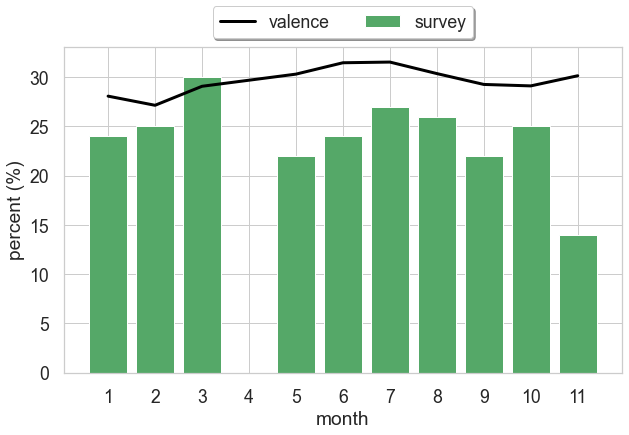

In [ ]:
# full

mon = df.groupby(['month'], as_index=False)[['month_resp_dob', 'prop_pos']].mean().iloc[:, 0].values
one = df.groupby(['month'], as_index=False)[['month_resp_dob', 'prop_pos']].mean().iloc[:, 1].values
two = df.groupby(['month'], as_index=False)[['month_resp_dob', 'prop_pos']].mean().iloc[:, 2].values

sns.set_theme(style="whitegrid")
plt.style.use("seaborn-talk")
sns.set(font_scale=1.6, style='whitegrid')

plt.figure(figsize = (10,6))
ax = sns.lineplot(x = mon, y = two, color='black', linewidth = 3, label='valence')
ax.bar(mon, one, color='g', label = 'survey')
plt.xlabel('month')
plt.ylabel('percent (%)')
plt.xticks(np.arange(1, 12, 1))
#plt.legend(loc= 4)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True, shadow=True)

#plt.savefig(f"fig{fig_num}.png")
plt.show()
fig_num += 1

plt.show()

In [ ]:
df.groupby(['month'], as_index=False)[['month_resp_zla', 'prop_neg']].mean()

,month,month_resp_zla,prop_neg
0,1,35.0,43.466667
1,2,39.0,44.323484
2,3,30.0,33.839567
3,5,42.0,32.284928
4,6,42.5,29.599946
5,7,40.0,29.839884
6,8,36.0,34.400388
7,9,41.0,35.644804
8,10,39.0,36.101611
9,11,45.0,33.724778


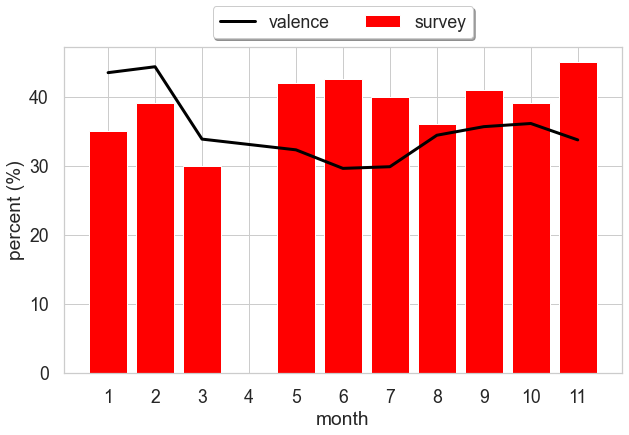

In [ ]:
# full

mon = df.groupby(['month'], as_index=False)[['month_resp_zla', 'prop_neg']].mean().iloc[:, 0].values
one = df.groupby(['month'], as_index=False)[['month_resp_zla', 'prop_neg']].mean().iloc[:, 1].values
two = df.groupby(['month'], as_index=False)[['month_resp_zla', 'prop_neg']].mean().iloc[:, 2].values

sns.set_theme(style="whitegrid")
plt.style.use("seaborn-talk")
sns.set(font_scale=1.6, style='whitegrid')

plt.figure(figsize = (10,6))
ax = sns.lineplot(x = mon, y = two, color='black', linewidth = 3, label='valence')
ax.bar(mon, one, color='red', label = 'survey')
plt.xlabel('month')
plt.xticks(np.arange(1, 12, 1))
plt.ylabel('percent (%)')
#plt.legend(loc= 4)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True, shadow=True)

#plt.savefig(f"fig{fig_num}.png")
plt.show()
fig_num += 1

plt.show()

# Other stats

In [16]:
from scipy.stats import pearsonr
from sklearn import metrics

In [ ]:
df_n = df.dropna(subset=['prop_neg'], axis=0)
print(df_n.shape)

(803039, 24)


In [ ]:
metrics.mean_absolute_error(df_n.month_resp_zla.values, df_n.prop_neg.values).round(3) # full data
# dupl 6.684
# uniq 6.88

6.88

In [ ]:
metrics.mean_absolute_error(df_n.month_resp_zla.values, df_n.prop_neg.values).round(3) # interia 2 uniq

3.276

In [ ]:
metrics.mean_absolute_error(df_n.month_resp_zla.values, df_n.prop_neg.values).round(3) # interia 2 duplicates

4.127

In [ ]:
df_n['mae'] = np.abs(df_n['month_resp_zla'] - df_n['prop_neg'])
df_n.groupby(['month'], as_index=False)[['month_resp_zla', 'prop_neg', 'mae']].mean()

,month,month_resp_zla,prop_neg,mae
0,1,35.0,43.466667,8.466667
1,2,39.0,44.323484,5.323484
2,3,30.0,33.839567,3.839567
3,5,42.0,32.284928,9.715072
4,6,42.5,29.599946,12.900054
5,7,40.0,29.839884,10.160116
6,8,36.0,34.400388,1.599612
7,9,41.0,35.644804,5.355196
8,10,39.0,36.101611,2.898389
9,11,45.0,33.724778,11.275222


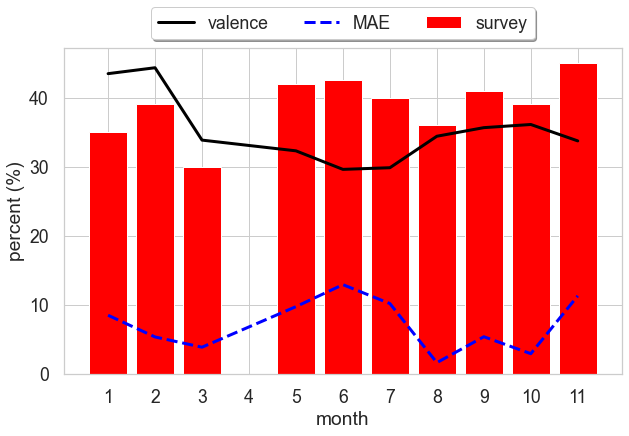

In [ ]:
# full

mon = df_n.groupby(['month'], as_index=False)[['month_resp_zla', 'prop_neg', 'mae']].mean().iloc[:, 0].values
one = df_n.groupby(['month'], as_index=False)[['month_resp_zla', 'prop_neg', 'mae']].mean().iloc[:, 1].values
two = df_n.groupby(['month'], as_index=False)[['month_resp_zla', 'prop_neg', 'mae']].mean().iloc[:, 2].values
mae_n = df_n.groupby(['month'], as_index=False)[['month_resp_zla', 'prop_neg', 'mae']].mean().iloc[:, 3].values

sns.set_theme(style="whitegrid")
plt.style.use("seaborn-talk")
sns.set(font_scale=1.6, style='whitegrid')

plt.figure(figsize = (10,6))
ax = sns.lineplot(x = mon, y = two, color='black', linewidth = 3, label='valence')
ax.bar(mon, one, color='red', label = 'survey')
ax.plot(mon, mae_n, color='blue', label = 'MAE', linestyle = '--', linewidth = 3)

plt.xlabel('month')
plt.xticks(np.arange(1, 12, 1))
plt.ylabel('percent (%)')
plt.title('\n')
#plt.legend(loc= 4)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True, shadow=True)

plt.savefig(f"fig{fig_num}.png")
plt.show()
fig_num += 1

plt.show()

In [ ]:
df_p = df.dropna(subset=['prop_pos'], axis=0)
print(df_p.shape)

(739875, 24)


In [ ]:
metrics.mean_absolute_error(df_p.month_resp_dob.values, df_p.prop_pos.values).round(3) # full data
# dupl 5.285
# uniq 5.119

5.119

In [ ]:
metrics.mean_absolute_error(df_p.month_resp_dob.values, df_p.prop_pos.values).round(3) # interia 2 uniq

4.063

In [ ]:
metrics.mean_absolute_error(df_p.month_resp_dob.values, df_p.prop_pos.values).round(3) # interia 2 duplicates

5.43

In [ ]:
df_p['mae'] = np.abs(df_p['month_resp_dob'] - df_p['prop_pos'])
df_p.groupby(['month'], as_index=False)[['month_resp_dob', 'prop_pos', 'mae']].mean()

,month,month_resp_dob,prop_pos,mae
0,1,24.0,28.066667,4.066667
1,2,25.0,27.138414,2.138414
2,3,30.0,29.067165,0.932835
3,5,22.0,30.300470,8.300470
4,6,24.0,31.454244,7.454244
5,7,27.0,31.524299,4.524299
6,8,26.0,30.355731,4.355731
7,9,22.0,29.254099,7.254099
8,10,25.0,29.107030,4.107030
9,11,14.0,30.136784,16.136784


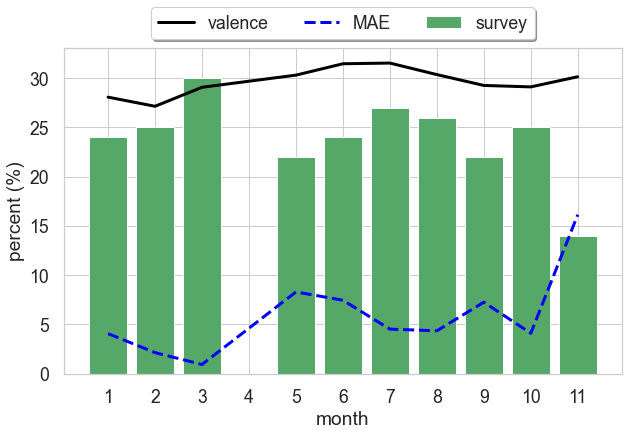

In [ ]:
# full

mon = df_p.groupby(['month'], as_index=False)[['month_resp_dob', 'prop_pos', 'mae']].mean().iloc[:, 0].values
one = df_p.groupby(['month'], as_index=False)[['month_resp_dob', 'prop_pos', 'mae']].mean().iloc[:, 1].values
two = df_p.groupby(['month'], as_index=False)[['month_resp_dob', 'prop_pos', 'mae']].mean().iloc[:, 2].values
mae_n = df_p.groupby(['month'], as_index=False)[['month_resp_dob', 'prop_pos', 'mae']].mean().iloc[:, 3].values

sns.set_theme(style="whitegrid")
plt.style.use("seaborn-talk")
sns.set(font_scale=1.6, style='whitegrid')
plt.figure(figsize = (10,6))

ax = sns.lineplot(x = mon, y = two, color='black', linewidth = 3, label='valence')
ax.bar(mon, one, color='g', label = 'survey')
ax.plot(mon, mae_n, color='blue', label = 'MAE', linestyle = '--', linewidth = 3)

plt.xlabel('month')
plt.xticks(np.arange(1, 12, 1))
plt.ylabel('percent (%)')
plt.title('\n')
#plt.legend(loc= 4)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True, shadow=True)

plt.savefig(f"fig{fig_num}.png")
plt.show()
fig_num += 1

plt.show()

# Sentiment BERT-model

In [ ]:
from transformers import pipeline

In [ ]:
model_path = "eevvgg/PaReS-sentimenTw-political-PL"
#model_path = "cardiffnlp/xlm-twitter-politics-sentiment" 

sentiment_task = pipeline(task = "sentiment-analysis", model = model_path, tokenizer = model_path)

In [3]:
df = pd.read_csv(r"C:\Users\User\Downloads\interia2_cln.csv", index_col=0)
df.shape

(647289, 23)

In [ ]:
sequence = df.content.to_list()

In [ ]:
sequence = [str(s) if len(str(s)) < 400 else str(s)[:400] for s in sequence]

In [ ]:
sequence[3102:3109]

['bzdura, ile jest osób nie ogarnietych statystyką np. tych co robią prywatnie, ile jest osób, które mają wynik, mieszkają rodziną to znaczy, że rodzina też ma, ile jest osób, które po kilkukodzinnym staniu kolejce odjeżdżają bo punkt zamknięty, ile jest takich co przechodzą chorobę nie ida na badania sam znam takich wielu już. oni sami sobie nakładaja kwarantannę siedzą domach. ten wynik to trzeba przez pomnożyć przynajmniej tego wynika, że mamy dobre ponad tys. zakażonych dziennie.',
 'tempe piśory zrzucają na nas polaków winę za zarażenia natomiast sami robią nam ogromne kuku, puszczając ludzi kwarantanny bez testu, jak żadnym kraju na świcie. teraz przykładowo połowa ludzi kończących danego dnia kwarantannę jest zarażonych ale nie miała objawów więc nic nikomu nie mówi że ma jakieś objawy, po kwarantannie wychodzi na ulicę sieje spustoszenie zarażając na mega skalę, oto głupota piśorowska działanie na szkodę polaków, dlaczego tak robią, bo pieniądze naszych podatków wydają n',
 'ta

In [5]:
result = sentiment_task(sequence)
len(result)

647289

In [7]:
labels = [i['label'] for i in result]
labels[:5]

['Negative', 'Negative', 'Negative', 'Positive', 'Negative']

In [ ]:
df['sentimentBERT'] = labels

## BERT analysis

In [109]:
df = df_all.copy()
df.shape

(2452868, 27)

In [110]:
df.sentimentBERT.value_counts(normalize=True)*100

Negative    82.617002
Neutral     12.733176
Positive     4.649822
Name: sentimentBERT, dtype: float64

In [111]:
df[['content', 'content_valence_score', 'sentimentBERT']].iloc[18000:18006]

,content,content_valence_score,sentimentBERT
18000,medycyna biologia to nie matematyka teoretyczna. od większości zasad mogą znaleźć się wyjątki. żadna szczepionka nie chroni % przed chorobą to samo można p...,-14.927608,Negative
18001,kolejna młoda osoba. gdyby nie ten cholerny covid (po raz kolejny) to żyłaby jak nic lat.,19.688359,Negative
18002,"niewątpliwie ciekawa informacja dotycząca letniej, chorej na raka. pewnością już jutro komuś uda się wysmażyć tego alarmujący artykuł tym, jak to wszyscy u...",-18.120266,Negative
18003,mogła jeszcze żyć ze lat...,14.484281,Negative
18004,"user pozostaniesz, naziolski oszuście.<br> masz informację, że odporność grupowa (herd immunity) to fikcja bo wirus ostro mutuje, ale lepiej się ponabijać.<...",-17.694443,Negative
18005,user ty masz nowotwór mózgu?,-21.258715,Negative


In [112]:
df_sent = pd.DataFrame(df.groupby(['month'])['sentimentBERT'].value_counts(normalize=True))*100
df_sent.columns = ['percentage']
df_sent = df_sent.reset_index()
df_sent

,month,sentimentBERT,percentage
0,1,Negative,85.733333
1,1,Neutral,11.666667
2,1,Positive,2.600000
3,2,Negative,87.169518
4,2,Neutral,10.419907
5,2,Positive,2.410575
6,3,Negative,82.642209
7,3,Neutral,13.044406
8,3,Positive,4.313385
9,5,Negative,82.607117


In [113]:
df['senti_neg'] = np.where(df.sentimentBERT == 'Negative', 1, 0)
df['senti_pos'] = np.where(df.sentimentBERT == 'Positive', 1, 0)

In [114]:
df.groupby(['month'], as_index=False)[['senti_neg', 'senti_pos']].mean()

,month,senti_neg,senti_pos
0,1,0.857333,0.026000
1,2,0.871695,0.024106
2,3,0.826422,0.043134
3,5,0.826071,0.046499
4,6,0.813567,0.058148
5,7,0.818662,0.054979
6,8,0.837075,0.038504
7,9,0.839669,0.037300
8,10,0.837059,0.039509
9,11,0.826627,0.039189


In [115]:
from scipy.stats import pearsonr
from sklearn import metrics

df_n = df.dropna(subset=['month_resp_zla'], axis=0)
print(df_n.shape)
df_n['senti_neg'] = df_n['senti_neg'] * 100

(2452868, 29)


In [116]:
df_mae = df_n.groupby(['month'], as_index=False)[['month_resp_zla', 'senti_neg']].mean()
df_mae['mae'] = np.abs(df_mae['month_resp_zla'] - df_mae['senti_neg'])
df_mae

,month,month_resp_zla,senti_neg,mae
0,1,35.0,85.733333,50.733333
1,2,39.0,87.169518,48.169518
2,3,30.0,82.642209,52.642209
3,5,42.0,82.607117,40.607117
4,6,42.5,81.356676,38.856676
5,7,40.0,81.866224,41.866224
6,8,36.0,83.707534,47.707534
7,9,41.0,83.966862,42.966862
8,10,39.0,83.705908,44.705908
9,11,45.0,82.662708,37.662708


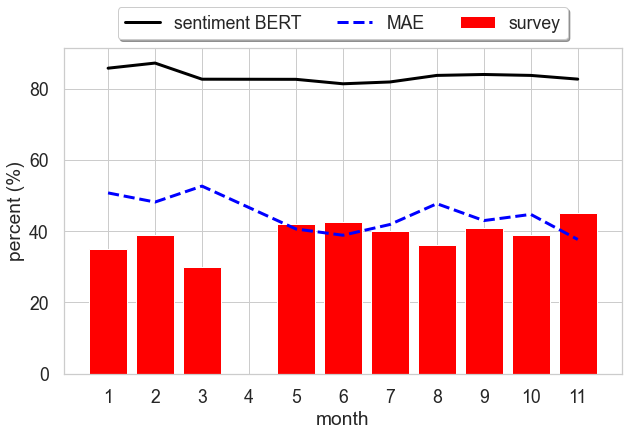

In [117]:
mon = df_mae.iloc[:, 0].values
one = df_mae.iloc[:, 1].values
two = df_mae.iloc[:, 2].values
mae_n = df_mae.iloc[:, 3].values

sns.set_theme(style="whitegrid")
plt.style.use("seaborn-talk")
sns.set(font_scale=1.6, style='whitegrid')

plt.figure(figsize = (10,6))
ax = sns.lineplot(x = mon, y = two, color='black', linewidth = 3, label='sentiment BERT')
ax.bar(mon, one, color='red', label = 'survey')
ax.plot(mon, mae_n, color='blue', label = 'MAE', linestyle = '--', linewidth = 3)

plt.xlabel('month')
plt.xticks(np.arange(1, 12, 1))
plt.ylabel('percent (%)')
plt.title('\n')
#plt.legend(loc= 4)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True, shadow=True)

plt.savefig(f"fig{fig_num}.png")
plt.show()
fig_num += 1

plt.show()

In [118]:
df_p = df.dropna(subset=['month_resp_dob'], axis=0)
print(df_p.shape)
df_p['senti_pos'] = df_p['senti_pos'] * 100

(2452868, 29)


In [119]:
df_mae = df_p.groupby(['month'], as_index=False)[['month_resp_dob', 'senti_pos']].mean()
df_mae['mae'] = np.abs(df_mae['month_resp_dob'] - df_mae['senti_pos'])
df_mae

,month,month_resp_dob,senti_pos,mae
0,1,24.0,2.600000,21.400000
1,2,25.0,2.410575,22.589425
2,3,30.0,4.313385,25.686615
3,5,22.0,4.649911,17.350089
4,6,24.0,5.814757,18.185243
5,7,27.0,5.497943,21.502057
6,8,26.0,3.850356,22.149644
7,9,22.0,3.729981,18.270019
8,10,25.0,3.950925,21.049075
9,11,14.0,3.918875,10.081125


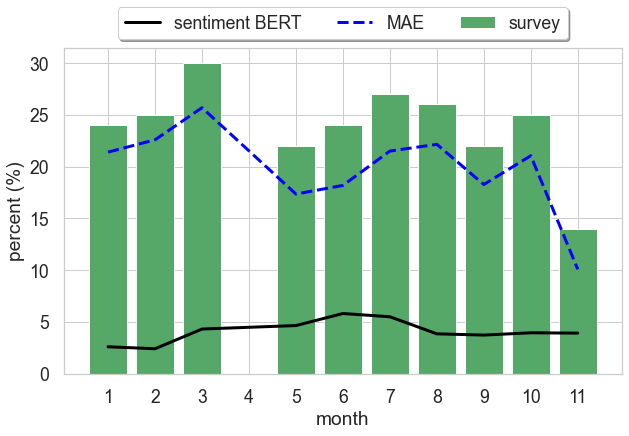

In [120]:
# full

mon = df_mae.iloc[:, 0].values
one = df_mae.iloc[:, 1].values
two = df_mae.iloc[:, 2].values
mae_n = df_mae.iloc[:, 3].values

sns.set_theme(style="whitegrid")
plt.style.use("seaborn-talk")
sns.set(font_scale=1.6, style='whitegrid')
plt.figure(figsize = (10,6))

ax = sns.lineplot(x = mon, y = two, color='black', linewidth = 3, label='sentiment BERT')
ax.bar(mon, one, color='g', label = 'survey')
ax.plot(mon, mae_n, color='blue', label = 'MAE', linestyle = '--', linewidth = 3)

plt.xlabel('month')
plt.xticks(np.arange(1, 12, 1))
plt.ylabel('percent (%)')
plt.title('\n')
#plt.legend(loc= 4)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True, shadow=True)

plt.savefig(f"fig{fig_num}.png")
plt.show()
fig_num += 1

plt.show()